In [8]:
from ObservationData import ObservationData, Corrector
from astropy.time import Time
from astropy.io import fits
import astroalign as aa
from tqdm import tqdm
import os


data_manager = ObservationData("/net/virgo01/data/users/tboersma/2025-04-30/")

end_jd = Time("2025-04-30 23:30").jd
data_manager.directory_frame.sort_values(by="JD", inplace=True)
print(data_manager.directory_frame)
data_manager.save_csv("raw_files.csv")
data_manager.filter(f"JD <= {end_jd}", replace=True)
data_manager.save_csv("file_data.csv")


                            FILENAME       OBJECT   FILTER IMAGETYP  \
244        LDST_250430-0001_Bias.fit  LDST_250430     None     BIAS   
76         LDST_250430-0002_Bias.fit  LDST_250430     None     BIAS   
146        LDST_250430-0003_Bias.fit  LDST_250430     None     BIAS   
91         LDST_250430-0004_Bias.fit  LDST_250430     None     BIAS   
18         LDST_250430-0005_Bias.fit  LDST_250430     None     BIAS   
..                               ...          ...      ...      ...   
58   LDST_250430-0003_Halphaflat.fit  LDST_250430  H_alpha     FLAT   
69   LDST_250430-0004_Halphaflat.fit  LDST_250430  H_alpha     FLAT   
266  LDST_250430-0005_Halphaflat.fit  LDST_250430  H_alpha     FLAT   
66         LDST_250430-0015_dark.fit  LDST_250430    ND1.2    LIGHT   
238        LDST_250430-0016_dark.fit  LDST_250430    ND1.2    LIGHT   

                   DATE-OBS EXP-TIME            JD  
244  2025-04-30T18:22:10.41     None  2.460796e+06  
76   2025-04-30T18:22:12.85     None  2.4

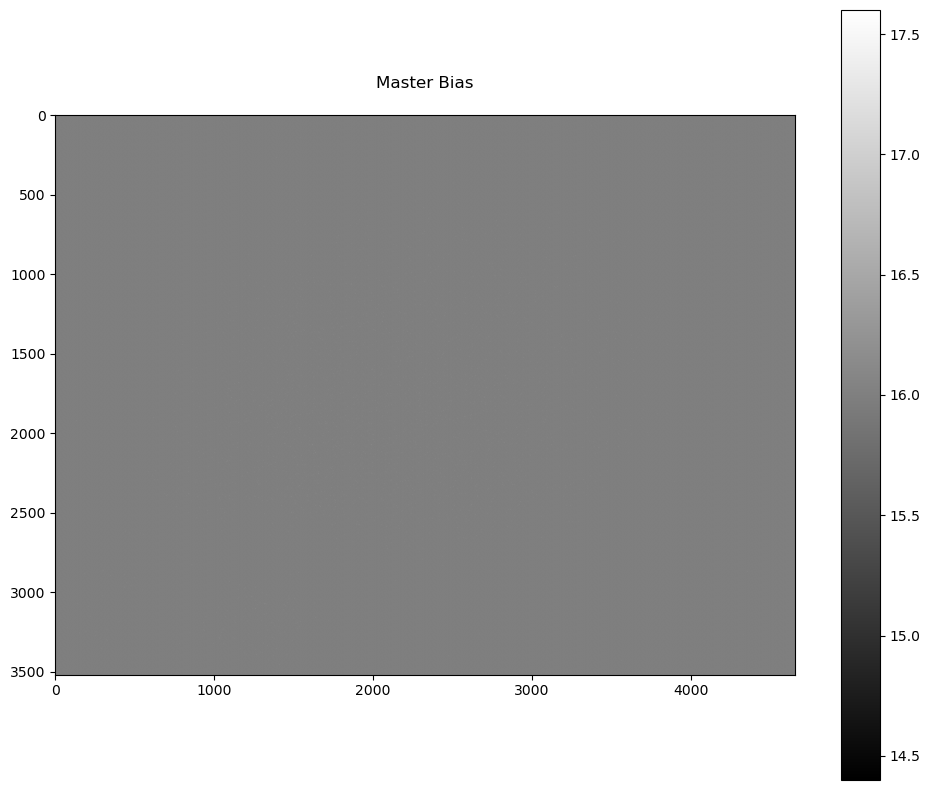

In [9]:
# Compute Master Bias
import numpy as np

bias_files = data_manager.filter(f"IMAGETYP == 'BIAS'", replace=False)["FILENAME"].tolist()

bias_data = data_manager.load_data(f"IMAGETYP == 'BIAS'")
master_bias = np.median(bias_data, axis=-1)

header = fits.getheader(os.path.join(data_manager.directory_path, bias_files[0]))
header['IMAGETYP'] = 'MASTER_BIAS'
header['NFRAMES'] = len(bias_data)
header['COMBINED'] = 'MEDIAN'
header['COMMENT'] = 'Master bias frame created from raw bias exposures'

fits.writeto(os.path.join(data_manager.directory_path, 'master_bias.fits'), master_bias, header, overwrite=True)
data_manager.add_file('master_bias.fits')

data_manager.plot_gray_scale(master_bias, "Master Bias")


{None, 'B*', 'H_alpha', 'G*', 'ND1.2', 'Lum', 'R*'}


  0%|          | 0/7 [00:00<?, ?it/s]

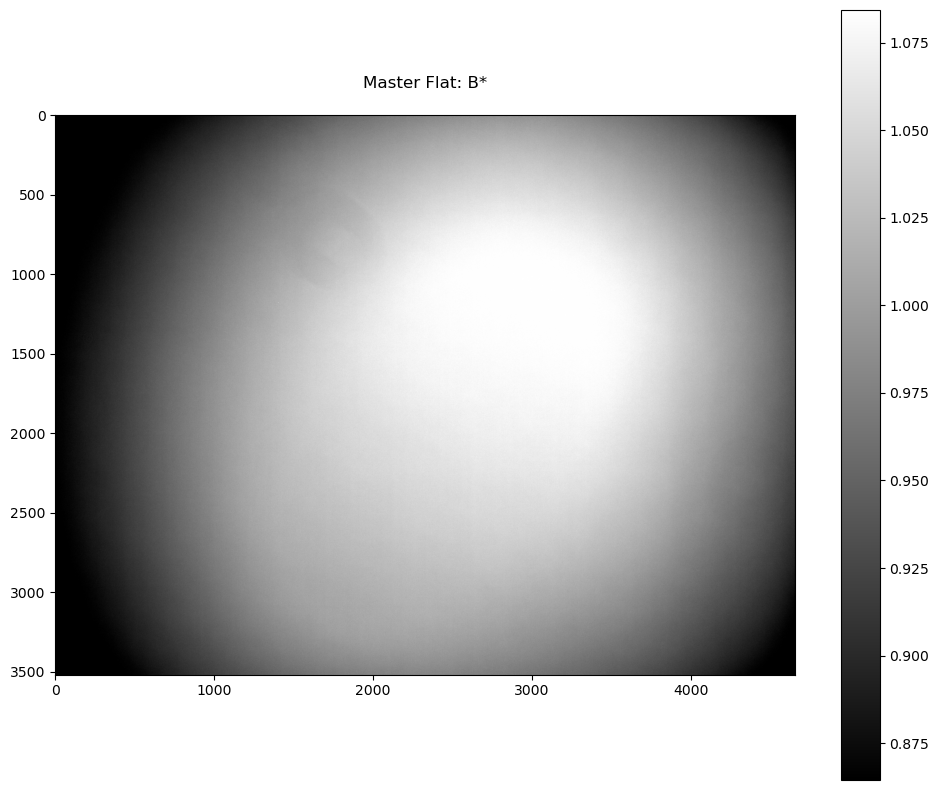

 29%|██▊       | 2/7 [00:05<00:14,  2.90s/it]

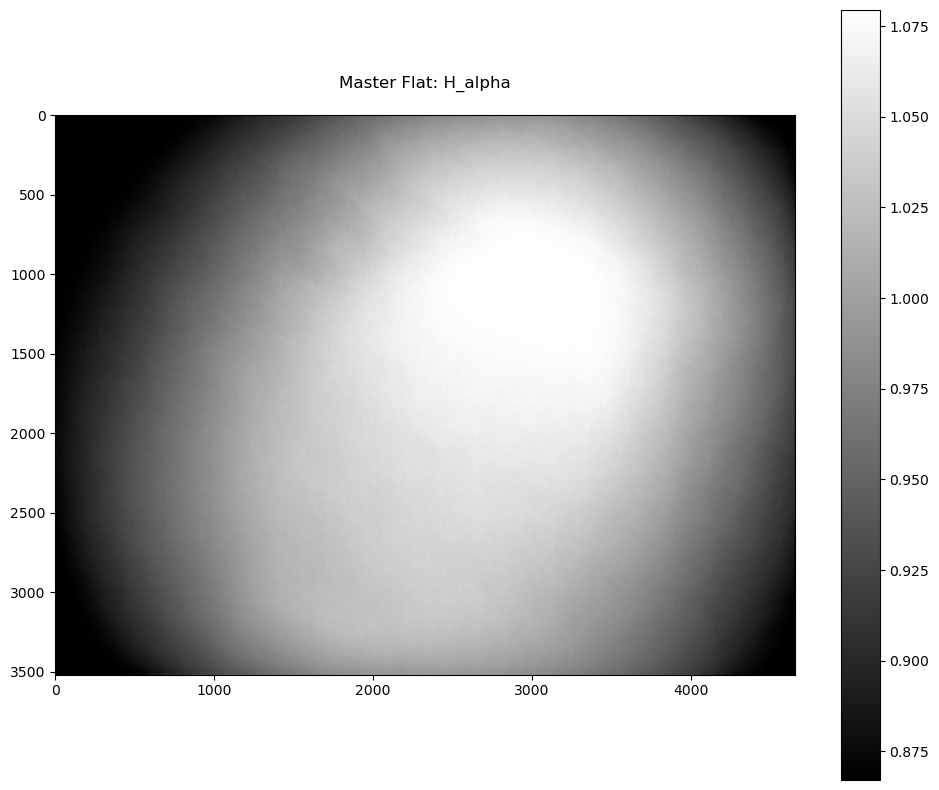

 43%|████▎     | 3/7 [00:10<00:15,  3.81s/it]

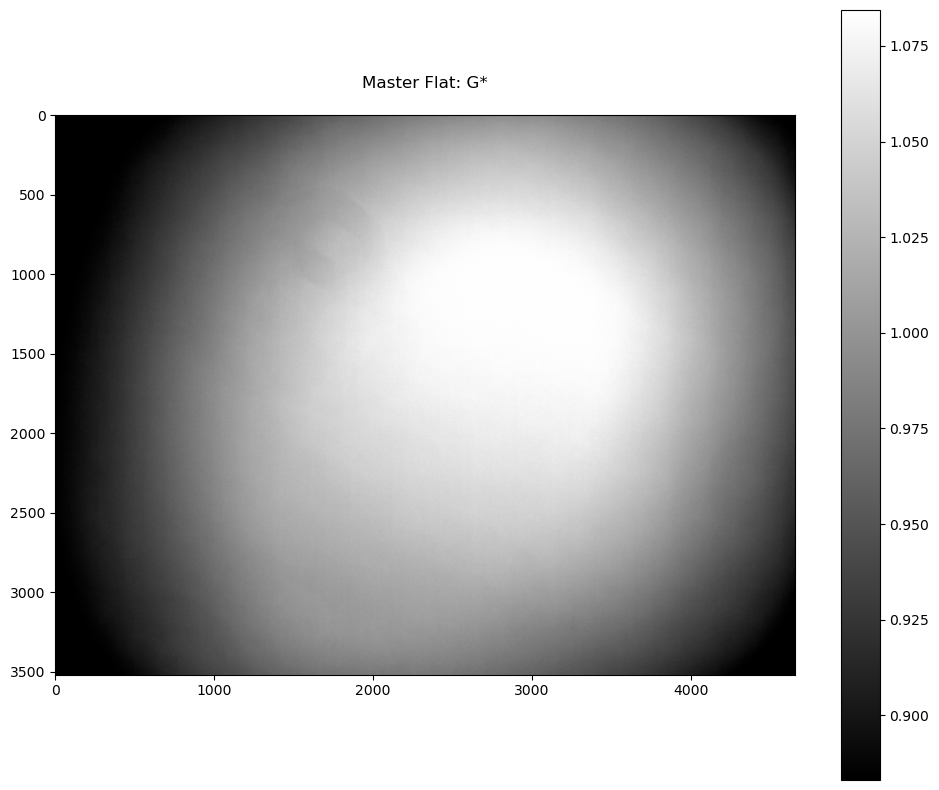

 57%|█████▋    | 4/7 [00:17<00:14,  4.84s/it]

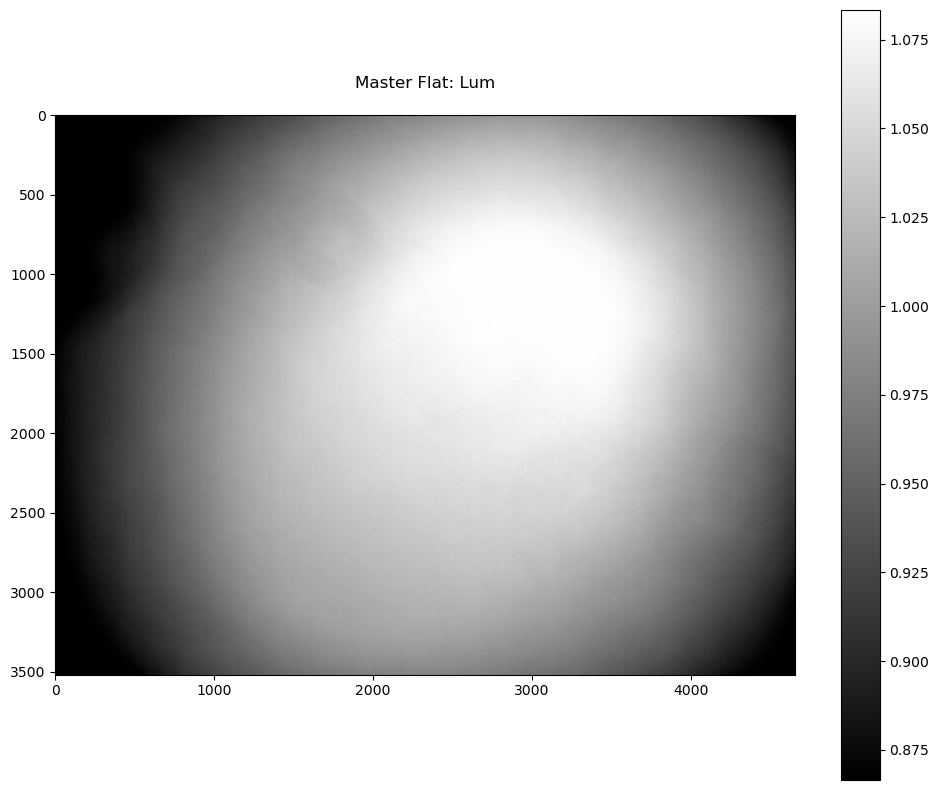

 86%|████████▌ | 6/7 [00:22<00:03,  3.66s/it]

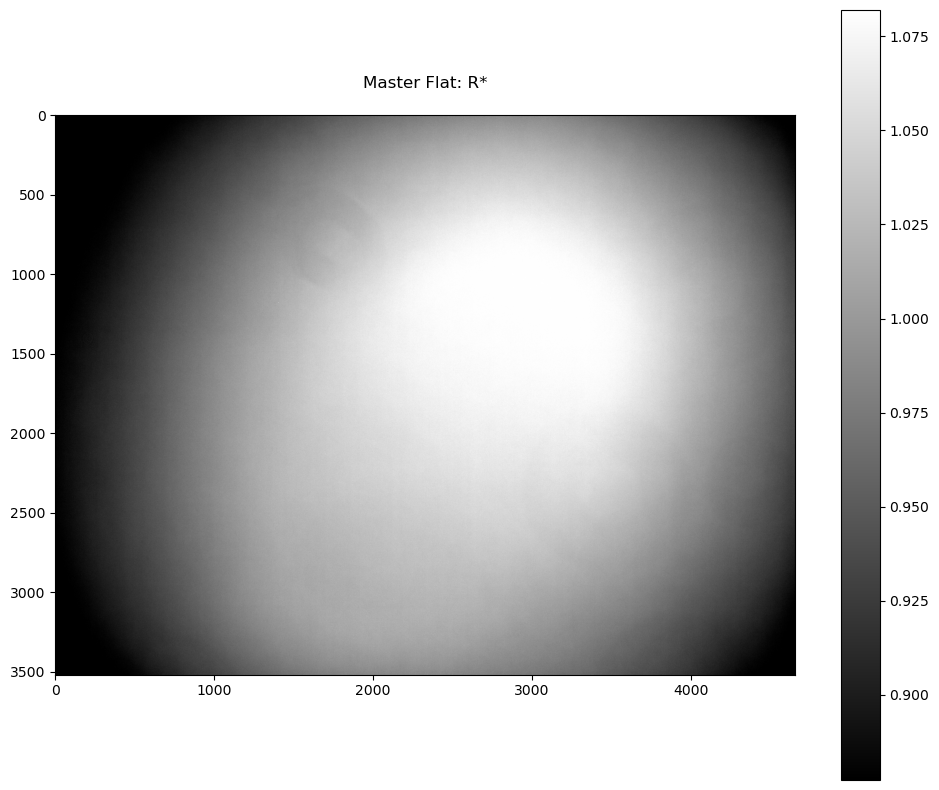

100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


In [10]:
# Compute Master FLATS
import numpy as np

flat_files = data_manager.filter("IMAGETYP == 'FLAT'", replace=False)
master_bias = fits.getdata(os.path.join(data_manager.directory_path, 'master_bias.fits'))


filters = set(data_manager.directory_frame["FILTER"])
print(filters)
flat_dict = {}

header = fits.getheader(os.path.join(data_manager.directory_path, flat_files['FILENAME'].tolist()[0]))
header['IMAGETYP'] = 'MASTER_BIAS'

header['COMBINED'] = 'MEDIAN'
header['COMMENT'] = 'Master bias frame created from normalized flat exposures'

for fil in tqdm(filters):
    if fil is None or fil == "ND1.2":
        continue
    
  
    
    flat_data = data_manager.load_data(f"IMAGETYP == 'FLAT' & FILTER == '{fil}'")
    normalized_data = (flat_data - master_bias[..., np.newaxis]) / np.median(flat_data, axis=(0,1))  
        
    flat_dict[fil] = np.median(normalized_data, axis=-1)

    header['NFRAMES'] = len(flat_data)
    header['FILTER'] = fil 
    
    data_manager.plot_gray_scale(flat_dict[fil], f"Master Flat: {fil}")
    
    fits.writeto(os.path.join(data_manager.directory_path, f'master_flat_{fil}.fits'), master_bias, header, overwrite=True)
    data_manager.add_file(f'master_flat_{fil}.fits')



In [12]:
import matplotlib.pyplot as plt

data_corrector = Corrector(master_bias, flat_dict)

img_files = data_manager.filter("IMAGETYP == 'LIGHT' & FILTER != 'ND1.2' & FILTER != 'None'")

for idx, row in tqdm(img_files.iterrows()):
    fp = row["FILENAME"]
    name = fp.split('_')[-1][:-4]
    
    data = fits.getdata(os.path.join(data_manager.directory_path, fp))
    
    corrected = data_corrector.correct(data, row["FILTER"])
    
    
    header = fits.getheader(os.path.join(data_manager.directory_path, fp))
    header['COMMENT'] = 'Reduced frame created from master_bias and master_flat'
    header['IMAGETYP'] = 'REDUCED'
    header['OBJECT'] = "M82" if len(name) < 4 else "STARFIELD"
    fits.writeto(os.path.join(data_manager.directory_path, f'reduced_{name}_{idx}.fits'), corrected, header, overwrite=True)
    data_manager.add_file(f'reduced_{name}_{idx}.fits')

128it [00:47,  2.70it/s]


In [13]:

reduced_files = data_manager.filter("IMAGETYP == 'REDUCED'")

targets = {}

for idx, row in tqdm(reduced_files.iterrows()):
    fp = row["FILENAME"]

    
    data = fits.getdata(os.path.join(data_manager.directory_path, fp))
    data = data.byteswap().newbyteorder()
    
    header = fits.getheader(os.path.join(data_manager.directory_path, fp))
    key = f"{header['OBJECT']}_{header['FILTER']}"
    
    if key not in targets.keys():
        targets[key] = data
        continue
    
    ref_data = targets[key].byteswap().newbyteorder()  # Ensure reference is also little-endian

    registered, _ = aa.register(data, ref_data)
    
    header = fits.getheader(os.path.join(data_manager.directory_path, fp))
    header['COMMENT'] = 'Registered frame created from master_bias and master_flat'
    header['IMAGETYP'] = 'REGISTERED'
    fits.writeto(os.path.join(data_manager.directory_path, f'reduced_{key}_{idx}.fits'), corrected, header, overwrite=True)
    data_manager.add_file(f'reduced_{key}_{idx}.fits')
    
    



47it [01:44,  2.22s/it]


MaxIterError: List of matching triangles exhausted before an acceptable transformation was found

In [6]:
from itertools import combinations


registered_files = data_manager.filter("IMAGETYP == 'REGISTERED'")
file = registered_files['FILENAME'].tolist()[0]
header = fits.getheader(os.path.join(data_manager.directory_path, file))
filters = set(registered_files["FILTER"])
objects = set(registered_files["OBJECT"])
pairs = combinations(filters, objects)

for fil, obj in pairs:
    data = data_manager.load_data(f"FILTER == '{fil} & '{obj}'")
    final = data.median(axis=-1)
    
    header['COMMENT'] = 'Finalized frame created from registered images'
    header['IMAGETYP'] = 'FINAL'
    fits.writeto(os.path.join(data_manager.directory_path, f'final_{obj}_{fil}.fits'), corrected, header, overwrite=True)
    data_manager.add_file(f'final_{obj}_{fil}.fits')
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/net/virgo01/data/users/tboersma/2025-04-30/reduced__53.fits'